In [408]:
#####Bi-level model for Rare temporal pattern detection####
import numpy as np
import pandas as pd
import matplotlib.pyplot  as plt
import numpy.matlib
import scipy.linalg
import itertools
import math
from scipy import sparse
from pandas.tools.plotting import scatter_matrix
from numpy.random import *
from scipy import optimize
import seaborn as sns
import time

#np.random.seed(98537)

In [409]:
##多項分布の乱数を生成する関数
def rmnom(pr, n, k, no):
    z_id = np.argmax((np.cumsum(pr, axis=1) >= np.random.uniform(0, 1, n)[:, np.newaxis]), axis=1)
    Z = sparse.coo_matrix((np.repeat(1, n), (no, np.array(z_id))), shape=(n, k))   #スパース行列の設定
    return Z

In [410]:
####データの発生####
##データの設定
k = 2   #混合数
m0 = 3   #正常状態での潜在変数数
m1 = 2   #異常状態での潜在変数数
hh = 5000   #ユーザー数
pt = np.random.poisson(np.random.gamma(45, 1/0.25, hh), hh)   #系列数
hhpt = np.sum(pt)   #総レコード数

In [411]:
##IDとインデックスを設定
#IDを設定
user_id = np.repeat(range(hh), pt)
pt_id = np.array(list(itertools.chain(*[np.array(range(pt[i]), dtype="int") for i in range(hh)])))

#インデックスを設定
index = np.arange(hhpt)
user_list = [i for i in range(hh)]
user_vec = [i for i in range(hh)]
for i in range(hh):
    user_list[i] = index[user_id==i]
    user_vec[i] = np.repeat(1, pt[i])

In [412]:
##潜在パラメータとユーザーの異常状態を生成
#潜在変数のパラメータ
alpha = np.repeat(1.0, m0*m0).reshape(m0, m0) + np.diag(np.repeat(1.5, m0))
pi = np.array([0.04])   #ユーザーの混合率
gamma = np.array([0.075, 0.6])   #正常状態と異常状態の切換率
delta = np.array([0.5])   #異常状態の混合率
omega0 = np.append(np.random.dirichlet(np.repeat(2.5, m0), 1).reshape(-1), 0) 
omega1 = np.append((1-gamma[0])*omega0[:m0], gamma[0])
theta0 = np.zeros((m0+1, m0+1))
for j in range(m0):
    theta0[j, :m0] = np.random.dirichlet(alpha[j, ], 1)
theta1 = np.hstack(((1-gamma[0])*theta0[:m0, :m0], np.repeat(gamma[0], m0)[:, np.newaxis]))
theta1 = np.vstack((theta1, np.append(((1-gamma[1])*np.random.dirichlet(np.repeat(1.0, m0))), gamma[1])))
pit = pi.copy(); gammat = gamma.copy(); deltat = delta.copy()
omegat0 = omega0.copy(); omegat1 = omega1.copy(); thetat0 = theta0.copy(); thetat1 = theta1.copy()
    
#ユーザーの潜在変数を生成
Z = np.random.binomial(1, pi, hh)
index_z = np.array(np.where(Z==1)[0], dtype="int")
n = index_z.shape[0]

#異常状態の潜在変数を生成
A = np.repeat(0, hh)
A[index_z] = np.random.binomial(1, delta, n) + 1

In [413]:
##ユーザーごとに系列の異常状態を生成
#データの格納用リスト
S_list = [i for i in range(hh)]
s_list = [i for i in range(hh)]

for i in range(hh):
    #系列の格納用配列
    S = np.array(np.zeros((pt[i], m0+1)), dtype="int")
    s = np.repeat(0, pt[i])

    #正常ユーザーの潜在変数を生成
    if Z[i]==0:
        for j in range(pt[i]):
            if j==0:
                S[j, ] = np.random.multinomial(1, omega0, 1)
            else:
                index = np.argmax(S[j-1, ])
                S[j, ] = np.random.multinomial(1, theta0[index, ])

    #異常ユーザーの潜在変数を生成
    else:
        for j in range(pt[i]):
            if j==0:
                S[j, ] = np.random.multinomial(1, omega1, 1)
                if S[j, m0]==1:
                    s[j, ] = 1
            else:
                index = np.argmax(S[j-1, ]) 
                S[j, ] = np.random.multinomial(1, theta1[index, ], 1)
                if S[j, m0]==1:
                    s[j] = 1
                    
    #生成したデータの格納
    S_list[i] = S
    s_list[i] = s

In [414]:
#リストを変換
S = np.array(list(itertools.chain(*[S_list[i] for i in range(hh)])))
s = np.array(list(itertools.chain(*[s_list[i] for i in range(hh)])))
s_vec = np.dot(S, np.arange(m0 + 1))
print(np.sum(S, axis=0))

[219220 395393 279547   5539]


In [415]:
##潜在変数からデータを生成
#妥当な数値が生成されるまで繰り返す
rp = 0
while True:
    rp = rp + 1
    print(rp)
    
    #ユーザーの入力変数を生成
    k1 = 4; k2 = 4; k3 = 5
    u1 = np.array(np.random.random(hh*k1)).reshape((hh, k1))
    u2 = np.zeros((hh, k2))
    for j in range(k2):
        prob = np.random.uniform(0.25, 0.55, 1)
        u2[:, j] = np.random.binomial(1, prob, hh)
    u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hh)
    u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
    x1 = np.concatenate((np.repeat(1, hh)[:, np.newaxis], u1, u2, u3), axis=1)

    #素性ベクトルを生成
    k1 = 5; k2 = 6; k3 = 4
    u1 = np.array(np.random.random(hhpt*k1)).reshape((hhpt, k1))
    u2 = np.zeros((hhpt, k2))
    for j in range(k2):
        prob = np.random.uniform(0.25, 0.55, 1)
        u2[:, j] = np.random.binomial(1, prob, hhpt)
    u3 = np.random.multinomial(1, np.random.dirichlet(np.repeat(3.0, k3), 1).reshape(k3), hhpt)
    u3 = np.delete(u3, np.argmin(np.sum(u3, axis=0)), axis=1)   #冗長な変数の削除
    x2 = np.concatenate((u1, u2, u3), axis=1)
    x = np.hstack((x1[user_id, ], x2))
    col_x = x.shape[1]
    
    #モデルパラメータを生成
    alpha0 = np.random.uniform(2.5, 3.0, m0)
    alpha1 = np.random.uniform(2.5, 3.0, m1)
    beta0 = np.append(np.random.uniform(0.7, 2.6, m0), np.random.normal(0, 0.4, (col_x-1)*m0)).reshape(col_x, m0)
    beta1 = np.append(np.array([np.random.uniform(-0.7, 0.1, 1), np.random.uniform(2.7, 3.4, 1)]).reshape(-1), 
                      np.random.normal(0, 0.4, (col_x-1)*m1)).reshape(col_x, m1)
    alphat0 = alpha0.copy(); alphat1 = alpha1.copy()
    betat0 = beta0.copy(); betat1 = beta1.copy()

    
    #正常値のデータを生成
    s_allocation = np.repeat(0, hhpt)
    s0_vec = np.dot(S[:, :m0], np.arange(m0))
    y = np.repeat(0.0, hhpt)
    index_s0 = np.array(np.where(s!=1)[0], dtype="int")
    N0 = index_s0.shape[0]
    mu = np.exp(np.sum(np.dot(x[index_s0, ], beta0) * S[index_s0, :m0], axis=1))
    y[index_s0] = np.random.gamma(mu, 1/alpha0[s0_vec[index_s0]], N0)

    #異常値のデータを生成
    index_s1 = np.array(np.where(s==1)[0], dtype="int")
    N1 = index_s1.shape[0]
    mu = np.exp(np.sum(np.dot(x[index_s1, ], beta1) * np.eye(m1)[A[user_id[index_s1]]-1], axis=1))
    y[index_s1] = np.random.gamma(mu, 1/alpha1[A[user_id[index_s1]]-1], N1)

    #応答変数の集計
    s_allocation = s_vec.copy()
    s_allocation[index_s1] = A[user_id[index_s1]] + m0 - 1
    y_mean = np.repeat(0.0, m0+m1)
    y_sd = np.repeat(0.0, m0+m1)
    for j in np.unique(s_allocation):
        index = np.where(s_allocation==j)[0]
        y_mean[j] = np.mean(y[index])
        y_sd[j] = np.std(y[index])

    #break条件
    if (np.min(y_mean[:m0]) > 1.5) & (np.max(y_mean[:m0]) < 12.0) & (y_mean[m0] < 1.0) & (y_mean[m0+1] > 12.5) & (y_mean[m0+1] < 20.0):
        break

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


[10.582  2.035  3.255  0.48  15.011]
[ 7.49   1.961  3.481  0.577 14.09 ]


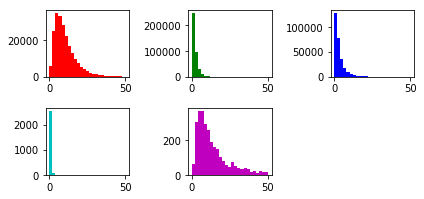

In [416]:
#生成したデータの確認
y_log = np.log(y)
print(np.round(y_mean, 3))
print(np.round(y_sd, 3))

#潜在変数ごとのヒストグラム
colorlist = ["r", "g", "b", "c", "m", "y", "k", "w"]
fig = plt.figure()
for j in range(m0+m1):
    ax = fig.add_subplot(3, 3, j+1)
    ax.hist(y[s_allocation==j],  bins=25, range=(0, 50), color=colorlist[j])
fig.tight_layout()
plt.show()

In [417]:
####マルコフ連鎖モンテカルロ法でパラメータを推定####
##ガンマ回帰の対数尤度
def loglike(alpha, beta, d, d_log, x):
    #対数尤度を設定
    mu = np.dot(x, alpha).reshape(-1)
    Lambda = np.exp(mu)   
    Lho = beta * (-d/Lambda - mu) + beta*np.log(beta) - math.lgamma(beta) + (beta-1)*d_log
    
    #対数尤度の和
    LL = np.sum(Lho)
    return LL, Lho 

##HMCで尺度パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_beta(beta, alpha, tau_inv, y, y_log, x):

    #ガンマ回帰モデルの対数尤度
    mu = np.dot(x, beta).reshape(-1)
    Lambda = np.exp(mu)
    Lho = np.sum(alpha * (-y/Lambda - mu) + alpha*np.log(alpha) - math.lgamma(alpha) + (alpha-1)*y_log)

    #多変量正規分布の対数事前分布
    log_mvn = -1/2 * np.dot(np.dot(beta, tau_inv), beta)

    #対数事後分布の和
    LL = Lho + log_mvn
    return LL

#ガンマ回帰の対数事後分布の微分関数
def dloglike_beta(beta, alpha, tau_inv, y, y_log, x, n):

    #期待値の設定
    mu = np.dot(x, beta).reshape(-1)
    Lambda = np.exp(mu)

    #微分関数の設定
    dlgamma = np.sum(((y-Lambda) / (np.power(Lambda, 2)/alpha) * Lambda).reshape(n, 1) * x, axis=0)
    dmvn = np.dot(-tau_inv, beta)

    #対数事後分布の微分関数の和
    LLd = -(dlgamma + dmvn)
    return LLd

#リープフロッグ法を解く関数
def leapfrog_beta(r, z1, D, e, L, alpha, tau_inv, y, y_log, x, n): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, alpha, tau_inv, y, y_log, x, n) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, alpha, tau_inv, y, y_log, x, n) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [418]:
##HMCで形状パラメータをサンプリングするための関数
#対数事後分布を計算する関数
def loglike_alpha(alpha, beta, y, y_log, x, new_si, new_Si, m0, m1):
    #期待値の設定
    alpha_vec = alpha[new_si]
    mu = np.dot(new_Si * np.dot(x, beta), np.repeat(1, m0+m1))
    Lambda = np.exp(mu)

    #対数尤度の和
    Lho = alpha_vec * (-y/Lambda - mu) + alpha_vec*np.log(alpha_vec) - scipy.special.gammaln(alpha)[new_si] + (alpha_vec-1)*y_log
    LL = np.sum(Lho)
    return LL

#形状パラメータの微分関数
def dloglike_alpha(alpha, beta, y, y_log, x, new_si, new_Si, m0, m1):
    #期待値の設定
    alpha_vec = alpha[new_si]
    mu = np.dot(new_Si * np.dot(x, beta), np.repeat(1, m0+m1))
    Lambda = np.exp(mu)

    #微分関数の和
    dlgamma0 = ((np.log(alpha_vec) - scipy.special.digamma(alpha)[new_si]) + 1 - y/Lambda + np.log(y/Lambda))[:, np.newaxis]
    dlgamma = -np.sum(new_Si * dlgamma0, axis=0)
    return dlgamma

#リープフロッグ法を解く関数
def leapfrog_alpha(r, z1, D, e, L, beta, y, y_log, x, new_si, new_Si, m0, m1): 
    def leapfrog_step(r, z1, e):
        r2 = r - e * D(z1, beta, y, y_log, x, new_si, new_Si, m0, m1) / 2
        z2 = z1 + e * r2
        r2 = r2 - e * D(z2, beta, y, y_log, x, new_si, new_Si, m0, m1) / 2
        return [r2, z2]   #1回の移動後の運動量と座標
    leapfrog_result = [r, z1]
    for i in range(L):
        leapfrog_result = leapfrog_step(leapfrog_result[0], leapfrog_result[1], e)
    return leapfrog_result

In [419]:
##アルゴリズムの設定
R = 2000
keep = 2
burnin = int(500/keep)
iter = 0
disp = 10
e1 = 0.001
e2 = 0.001
L = 3

In [420]:
##インデックスの設定
#先頭と後尾のインデックスを作成
max_pt = np.max(pt_id) + 1
index_t1 = np.array(np.where(pt_id==0)[0], dtype="int")
index_t12 = np.repeat(0, hh)
for i in range(hh):
    index_t12[i] = np.max(user_list[i])
    
#中間のインデックスを作成
index_list_t21 = [j for j in range(max_pt-1)]
index_list_t22 = [j for j in range(max_pt-1)]
for j in range(1, max_pt):
    index_list_t21[j-1] = np.array(np.where(pt_id==j)[0], dtype="int") - 1
    index_list_t22[j-1] = np.array(np.where(pt_id==j)[0], dtype="int")
index_t21 = np.sort(np.array(list(itertools.chain(*[index_list_t21[j] for j in range(max_pt-1)]))))
index_t22 = np.sort(np.array(list(itertools.chain(*[index_list_t22[j] for j in range(max_pt-1)]))))

In [421]:
##事前分布の設定
#潜在変数の事前分布
a0 = 1; b0 = 1
alpha01 = 0.1
alpha02 = 1.0

#ガンマ回帰の事前分布
tau = np.diag(np.repeat(100, col_x))
tau_inv = np.linalg.inv(tau)

In [427]:
##パラメータの真値
#潜在変数の割当率のパラメータの真値
pi = pit.copy()  
gamma = gammat.copy()
delta = deltat.copy()
omega0 = omegat0.copy()
omega1 = omegat1.copy()
theta0 = thetat0.copy()
theta1 = thetat1.copy()

#潜在変数の真値
Zi = Z
Ai = A
si = s
Si = S.copy()
Si0 = Si[:, :m0].copy()
Si0[np.where(Si[:, m0]==1)[0], ] = np.random.multinomial(1, omega0[:m0], np.sum(Si[:, m0]))
new_Si = np.hstack((Si[:, :m0], Si[:, m0][:, np.newaxis] * np.array(np.eye(m1+1), dtype="int")[Ai[user_id]][:, 1:]))
new_si = np.dot(new_Si, np.arange(m0+m1))
s0_vec = np.dot(Si0, np.arange(m0))
s1_vec = np.dot(Si, np.arange(m0+1))

#モデルパラメータの真値
alpha0 = alphat0
alpha1 = alphat1
alphat = np.append(alpha0, alpha1); alpha = alphat.copy()
beta0 = betat0
beta1 = betat1
betat = np.hstack((beta0, beta1)); beta = betat.copy()
np.sum(new_Si, axis=0)

array([219220, 395393, 279547,   2614,   2925])

In [428]:
##対数尤度の基準値
#真値での対数尤度
LLbest = loglike_alpha(alpha, beta, y, y_log, x, new_si, new_Si, m0, m1)
print(LLbest)

-2350313.191888656


In [429]:
####パラメータをサンプリング####
for rp in range(R):

    ##ユーザーの状態ごとの潜在変数を生成
    #潜在変数ごとのガンマ回帰の尤度
    Lho = np.zeros((hhpt, m0+m1))
    for j in range(m0+m1):
        Lho[:, j] = np.exp(loglike(beta[:, j], alpha[j], y, y_log, x)[1])
    Lho_new = np.hstack((Lho[:, :m0], np.sum(Lho[:, m0:], axis=1)[:, np.newaxis]))

    #HMMの混合率と推移確率
    theta_dt01 = np.full((hhpt, m0), 1/m0); theta_dt02 = theta_dt01.copy()
    theta_dt11 = np.full((hhpt, m0+1), 1/(m0+1)); theta_dt12 = theta_dt11.copy()
    theta_dt01[index_t1, ] = np.full((hh, m0), omega0[:m0])
    theta_dt01[index_t22, ] = theta0[:m0, :m0][s0_vec[index_t21], ]
    theta_dt02[index_t21, ] = (theta0[:m0, :m0].T)[s0_vec[index_t22], ]
    theta_dt11[index_t1, ] = np.full((hh, m0+1), omega1)
    theta_dt11[index_t22, ] = theta1[s1_vec[index_t21], ]
    theta_dt12[index_t21, ] = (theta1.T)[s1_vec[index_t22], ]

    #潜在変数ごとの事後分布と期待値
    Posterior0 = theta_dt01 * theta_dt02 * Lho_new[:, :m0]
    Posterior1 = theta_dt11 * theta_dt12 * Lho_new
    new_posterior0 = np.dot(Posterior0, np.repeat(1, m0))[:, np.newaxis]
    new_posterior1 = np.dot(Posterior1, np.repeat(1, m0+1))[:, np.newaxis]

    #ユーザーごとの潜在変数の事後分布
    pi_vec = np.append(1-pi, pi)
    new_posterior = np.zeros((hh, 2))
    for i in range(hh):
        index = user_list[i]
        Posterior = np.sum(np.log(np.hstack((new_posterior0[index, ], new_posterior1[index, ]))), axis=0)
        new_posterior[i, ] = pi_vec * np.exp(Posterior - np.max(Posterior))   #ユーザーごとの潜在変数の事後分布

    #ベルヌーイ分布からユーザーの状態をサンプリング
    z_rate = new_posterior / np.sum(new_posterior, axis=1)[:, np.newaxis]   #潜在変数の割当確率
    Zi = np.random.binomial(1, z_rate[:, 1], hh)
    index_z = np.array(np.where(Zi==1)[0], dtype="int")
    n = index_z.shape[0]

    ##観測ごとの潜在状態をサンプリング
    #潜在状態の割当確率
    s_rate0 = Posterior0 / np.dot(Posterior0, np.repeat(1, m0))[:, np.newaxis]
    s_rate1 = Posterior1 / np.dot(Posterior1, np.repeat(1, m0+1))[:, np.newaxis]

    #多項分布から潜在状態をサンプリング
    Si0 = np.array(rmnom(s_rate0, hhpt, m0, np.arange(hhpt)).todense())
    Si1 = np.array(rmnom(s_rate1, hhpt, m0+1, np.arange(hhpt)).todense())
    s0_vec = np.dot(Si0, np.arange(m0))
    s1_vec = np.dot(Si1, np.arange(m0 + 1))

    #ユーザーの状態に応じて潜在状態を割り当てる
    Ai = np.repeat(0, hh)
    Posterior_A = np.zeros((n, 2))
    Si = np.hstack((Si0, np.repeat(0, hhpt)[:, np.newaxis]))
    for i in range(n):
        index = user_list[index_z[i]]
        Si[index, ] = Si1[index, ]

        #ユーザーの異常状態の事後分布
        index_s = np.where(Si[index, m0]==1)[0]
        Lho_new = np.sum(np.log(Lho[index, m0:][index_s, ]), axis=0)
        Posterior_A[i, ] = np.append(1-delta, delta) * np.exp(Lho_new - np.max(Lho_new))

    #潜在状態をベクトルに変換
    s_vec = np.dot(Si, np.arange(m0+1))

    #ベルヌーイ分布からユーザーの異常状態をサンプリング
    A_rate = Posterior_A / np.sum(Posterior_A, axis=1)[:, np.newaxis]
    ai = np.random.binomial(1, A_rate[:, 1], n) 
    Ai[index_z] = ai + 1

    ##混合率とマルコフ推移行列をサンプリング
    #ユーザー状態の混合率をサンプリング
    a = n + a0
    b = hh + b0
    pi = np.random.beta(a, b, 1)

    #異常状態のタイプの混合率をサンプリング
    a = np.sum(ai) + a0
    b = n + b0
    delta = np.random.beta(a, b, 1)

    #正常状態と異常状態の切換確率をサンプリング
    rf = np.dot(Si[index_t21, ].T, Si[index_t22, ])
    f = np.sum(pt[index_z]) - np.sum(rf[m0, ])
    a = np.sum(rf[:m0, m0]) + a0
    b = f - a + b0
    theta_m1 = np.random.dirichlet(rf[m0, ] + alpha01, 1).reshape(-1)
    gamma = np.append(np.random.beta(a, b, 1), theta_m1[m0])

    #マルコフ推移状列をサンプリング
    rf1 = np.sum(Si[index_t1, ], axis=0)[:m0] + alpha01
    rf2 = rf[:m0, :m0] + alpha02
    omega0 = np.append(np.random.dirichlet(rf1, 1).reshape(-1), 0)
    omega1 = np.append((1-gamma[0])*omega0[:m0], gamma[0])
    theta0 = np.zeros((m0+1, m0+1))
    for j in range(m0):
        theta0[j, :m0] = np.random.dirichlet(rf2[j, ], 1)
    theta1 = np.vstack((np.hstack(((1-gamma[0])*theta0[:m0, :m0], np.repeat(gamma[0], m0)[:, np.newaxis])), theta_m1))

    ##ガンマ回帰モデルのパラメータをサンプリング
    #データの設定
    new_Si = np.hstack((Si[:, :m0], Si[:, m0][:, np.newaxis] * np.array(np.eye(m1+1), dtype="int")[Ai[user_id]][:, 1:]))
    accept_prob1 = np.repeat(0.0, m0+m1)
    
    ##回帰パラメータをサンプリング
    for j in range(m0+m1):
        #潜在変数ごとのデータを抽出
        index = np.array(np.where(new_Si[:, j]==1)[0], dtype="int")
        y1 = y[index]; x1 = x[index, ]
        n = index.shape[0]

        #HMCの新しいパラメータを生成
        rold = np.random.normal(0, 1, col_x)
        betad = beta[:, j]

        #リープフロッグ法による1ステップ移動
        y1_log = np.log(y1)
        res = leapfrog_beta(rold, betad, dloglike_beta, np.min(np.array([e1, 1/(n/100)])), L, alpha[j], tau_inv, y1, y1_log, x1, n)
        rnew = res[0]
        betan = res[1]

        #移動前と移動後のハミルトニアン
        Hnew = -loglike_beta(betan, alpha[j], tau_inv, y1, y1_log, x1) + np.sum(np.power(rnew, 2)) / 2
        Hold = -loglike_beta(betad, alpha[j], tau_inv, y1, y1_log, x1) + np.sum(np.power(rold, 2)) / 2

        #新しいパラメータの採択を決定
        rand = np.random.uniform(0, 1, 1)
        accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
        accept_prob1[j] = accept_prob

        #採択率に基づきalphaを採択
        if(accept_prob >= rand):
            beta[:, j] = betan
        else:
            beta[:, j] = betad

    ##サンプリング結果の格納と表示
    if rp%keep==0:
        mkeep = int(rp/keep)

    if rp%disp==0:
        #対数尤度を更新
        LL = loglike_alpha(alpha, beta, y, y_log, x, new_si, new_Si, m0, m1)
        
        #サンプリング結果を表示
        print(rp)
        print(np.round([LL, LLbest], 1))
        print(np.round(accept_prob1, 3))
        print(np.round(accept_prob2, 3))

0
[-2058281.  -2350313.2]
[0. 1. 1. 1. 1.]
1.0


C:\Users\sana\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: divide by zero encountered in log


10
[-1877319.5 -2350313.2]
[1. 1. 1. 1. 1.]
1.0
20
[-1719210.7 -2350313.2]
[1. 1. 1. 1. 1.]
1.0
30
[-1729119.5 -2350313.2]
[1. 1. 1. 1. 1.]
1.0
40
[-1737122.5 -2350313.2]
[1. 1. 1. 1. 1.]
1.0
50
[-1725925.3 -2350313.2]
[1. 1. 1. 1. 1.]
1.0
60
[-1714835.6 -2350313.2]
[1. 1. 1. 1. 1.]
1.0
70
[-1707605.2 -2350313.2]
[1. 1. 1. 1. 1.]
1.0
80
[-1703499.2 -2350313.2]
[0.96 1.   1.   1.   1.  ]
1.0
90
[-1700479.3 -2350313.2]
[0.99  0.994 1.    1.    1.   ]
1.0
100
[-1698506.  -2350313.2]
[1. 1. 1. 1. 1.]
1.0
110
[-1698647.2 -2350313.2]
[0.977 1.    1.    1.    1.   ]
1.0
120
[-1696835.3 -2350313.2]
[0.647 1.    1.    1.    1.   ]
1.0
130
[-1699053.  -2350313.2]
[0.934 1.    1.    1.    1.   ]
1.0
140
[-1698112.8 -2350313.2]
[1.    0.983 1.    1.    1.   ]
1.0
150
[-1698095.6 -2350313.2]
[1. 1. 1. 1. 1.]
1.0
160
[-1700007.8 -2350313.2]
[1.    1.    0.999 1.    1.   ]
1.0
170
[-1698945.7 -2350313.2]
[1. 1. 1. 1. 1.]
1.0
180
[-1699584.7 -2350313.2]
[1.    0.963 1.    1.    1.   ]
1.0
190
[-170053

KeyboardInterrupt: 

In [435]:
np.sum(np.hstack((Si[:, :m0], Si[:, m0][:, np.newaxis] * np.array(np.eye(m1+1), dtype="int")[Ai[user_id]][:, 1:])), axis=0)

array([200703,  36553,   6078, 364738, 291627])

array([2, 2, 2, ..., 1, 1, 1])

In [438]:
np.sum(Si, axis=0)

array([200703,  36553,   6078, 656365])

In [439]:
np.sum(new_Si * np.exp(np.dot(x, beta)), axis=0) / np.sum(new_Si, axis=0)

array([11.14840215,  1.27129625,  0.22933217,  2.66609739,  2.8632432 ])

In [386]:
np.sum(new_Si, axis=0)

array([177312, 331955, 383896,   2799,   3121])

In [395]:
j = 3
print(beta[:, j])
print(betat[:, j])

[-0.73393919  0.12882148  0.0207376   0.13458205 -0.16859015 -0.27753421
  0.0500827   0.2855864  -0.06200178 -0.33179329  0.20356051  0.72064516
 -0.05307735 -0.33202463 -0.30670984 -0.12779166 -0.43230234  0.44578529
  0.10329185 -0.05554606  0.08082565 -0.07177835 -0.2869069   0.40890783
  0.09088224 -0.68427565  0.24786343]
[-0.52750493  0.26308286  0.14548734  0.19238606 -0.10113327 -0.16344032
  0.05445167  0.34027242  0.01874557 -0.25349938  0.26181864  0.75032671
  0.01488661 -0.20181866 -0.26935252 -0.0021948  -0.35109905  0.52256305
  0.11087227  0.01899344  0.18409064  0.00233622 -0.1906237   0.45384194
  0.20844289 -0.59919721  0.32434356]


In [392]:

    ##形状パラメータをサンプリング
    #HMCの新しいパラメータを生成
    rold = np.random.normal(0, 1, m0+m1)
    alphad = alpha.copy()

    #リープ・フロッグ法による1ステップ移動
    res = leapfrog_alpha(rold, alphad, dloglike_alpha, e2, L, beta, y, y_log, x, new_si, new_Si, m0, m1)
    rnew = res[0]
    alphan = res[1]

    #移動前と移動後のハミルトニアン
    Hnew = -loglike_alpha(alphan, beta, y, y_log, x, new_si, new_Si, m0, m1)# + np.sum(np.power(rnew, 2))/2
    Hold = -loglike_alpha(alphad, beta, y, y_log, x, new_si, new_Si, m0, m1)# + np.sum(np.power(rold, 2))/2

    #新しいパラメータの採択を決定
    rand = np.random.uniform(0, 1, 1)
    accept_prob = np.min(np.append(1, np.exp(Hold - Hnew)))   #採択率
    accept_prob2 = accept_prob.copy()

    #採択率に基づきalphaを採択
    if(accept_prob >= rand):
        alpha = alphan
    else:
        alpha = alphad

array([ 2.21512943, 10.20491501,  2.66743427,  1.86756473,  2.97852619])